In [53]:
!pip install paddlepaddle paddleocr
!pip install pdf2image
!pip install pillow opencv-python
!pip install --quiet pymupdf
!pip install tools
!apt-get update
!apt-get install -y poppler-utils  # For PDF conversion
!apt-get install -y libzbar0
!pip install pyzbar
!pip install gdown
!gdown --id 13XO97_LdrC_VPCe4jZDGTno0iATnSAFi -O myfile.zip
!unzip myfile.zip
!pip install ultralytics
!pip install onnxruntime
!pip install insightface

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://cli.github.com/packages stable InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading packag

In [54]:
import os
import json
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
import base64
from io import BytesIO
from paddleocr import PaddleOCR
from pdf2image import convert_from_path
import tempfile
import re
from PIL import Image, ImageDraw, ImageFilter
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from insightface.app import FaceAnalysis
from google.colab import files
import fitz  # PyMuPDF
import io
from ultralytics import YOLO

In [55]:
tokenizer = AutoTokenizer.from_pretrained("ai4bharat/IndicNER")
model = AutoModelForTokenClassification.from_pretrained("ai4bharat/IndicNER")
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

Device set to use cpu


In [56]:
app = FaceAnalysis(name="buffalo_l")

/usr/local/lib/python3.12/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5


In [57]:
ocr = PaddleOCR(
    use_doc_orientation_classify=False,
    use_doc_unwarping=False,
    use_textline_orientation=False)

Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/root/.paddlex/official_models/PP-OCRv5_server_det`.
Creating model: ('PP-OCRv5_server_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/root/.paddlex/official_models/PP-OCRv5_server_rec`.


In [58]:
def upload_and_convert(dpi=300):
    """
    Upload a PDF or image file in Google Colab.
    - If PDF → converts each page to a PIL Image at given DPI.
    - If image → loads directly as PIL Image.

    Returns:
        List of PIL Images
    """
    uploaded = files.upload()
    images = []

    zoom = dpi / 72  # scale factor (72 is default PDF dpi)
    mat = fitz.Matrix(zoom, zoom)

    for filename in uploaded.keys():
        file_path = filename
        print(f"Uploaded file: {file_path}")

        if file_path.lower().endswith(".pdf"):
            print(f"Converting PDF pages to images at {dpi} DPI...")
            pdf_doc = fitz.open(file_path)
            for page_num in range(len(pdf_doc)):
                page = pdf_doc[page_num]
                pix = page.get_pixmap(matrix=mat)  # 🔥 high-res render
                img = Image.open(io.BytesIO(pix.tobytes("png")))
                images.append(img)
                display(img)
        else:
            print("Processing as Image...")
            img = Image.open(file_path)
            images.append(img)
            display(img)

    return images


Saving Patient HealthCare Record_page-0001.jpg to Patient HealthCare Record_page-0001.jpg
Uploaded file: Patient HealthCare Record_page-0001.jpg
Processing as Image...


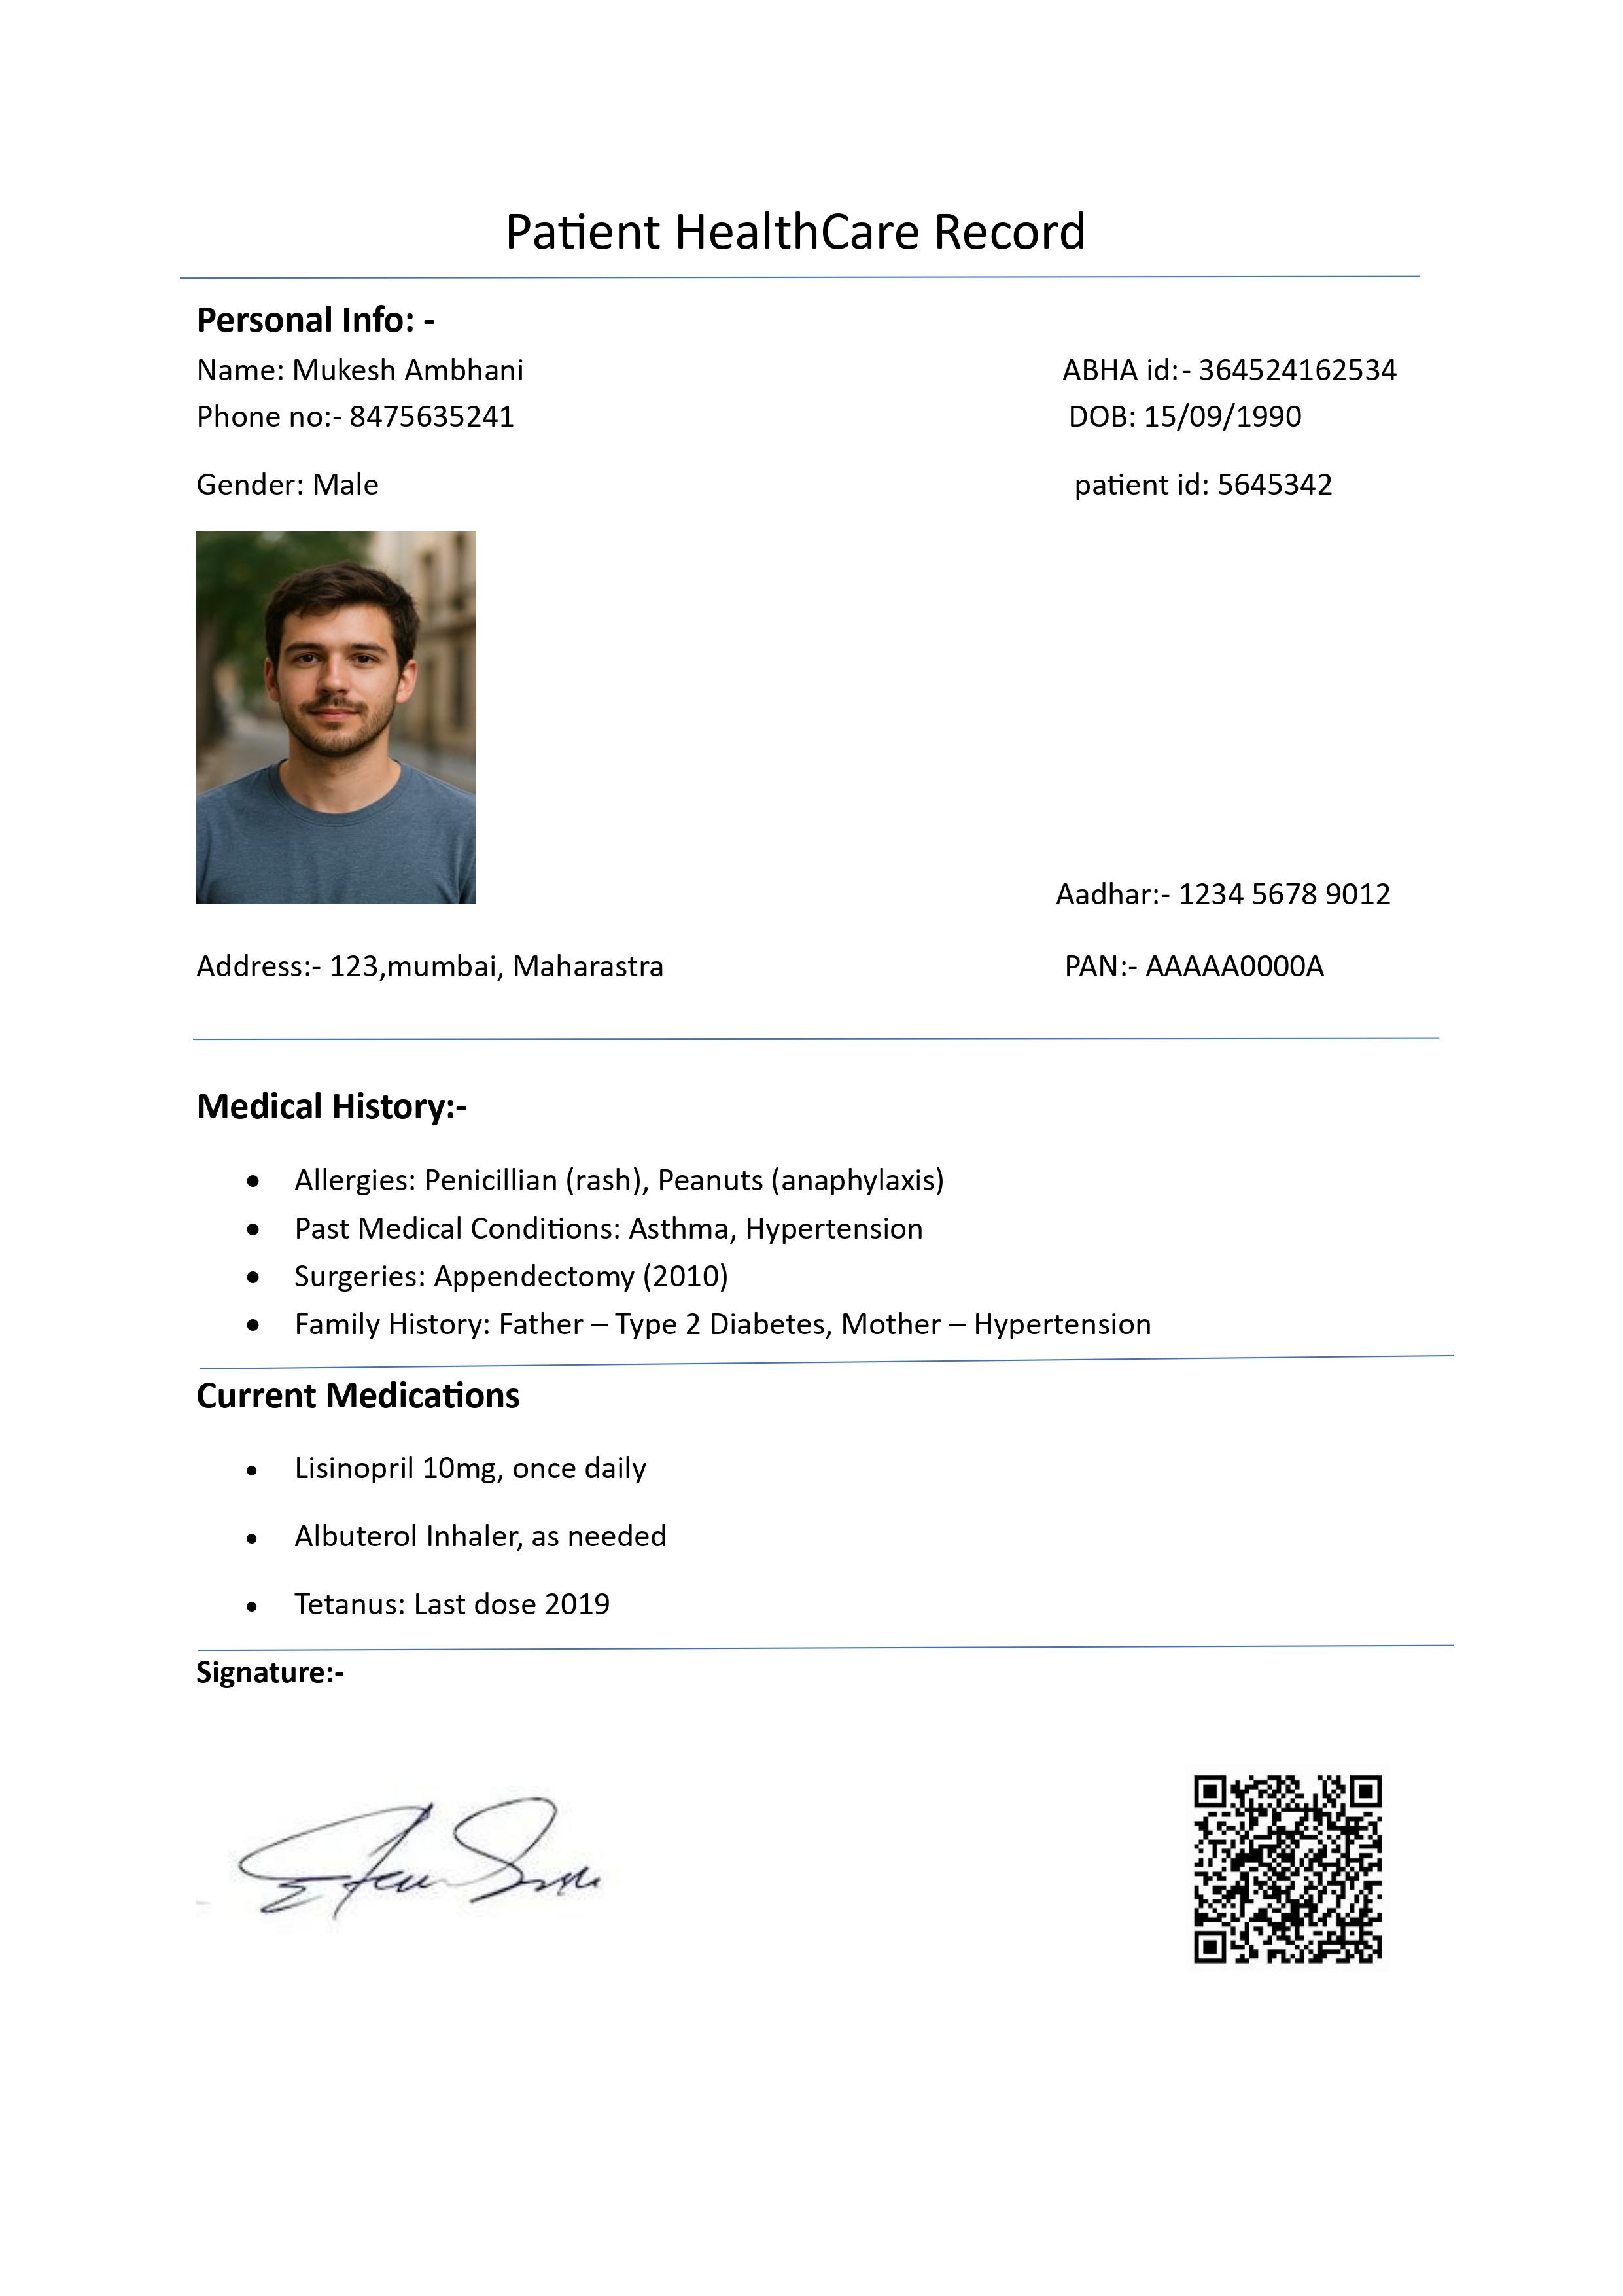

Total images: 1


In [59]:
images = upload_and_convert()

print(f"Total images: {len(images)}")
# Now you can pass `images` into OCR or further processing


In [140]:
results = []
for img in images:
    img_np = np.array(img)
    res = ocr.predict(img_np)
    results.extend(res)

In [170]:
def extract_text_with_boxes_from_list(data):
    """
    Extracts recognized texts, confidence scores, and bounding boxes
    from a list of OCR page results.
    """
    results = []

    # Loop through each page in the list
    for page_idx, page in enumerate(data):
        texts = page.get("rec_texts", [])
        boxes = page.get("rec_boxes", [])
        scores = page.get("rec_scores", [])

        for text, box, score in zip(texts, boxes, scores):
            results.append({
                "page": page_idx,              # page number
                "text": text,                  # recognized text
                "confidence": round(score, 3), # confidence score
                "box": box.tolist() if hasattr(box, "tolist") else box  # convert np.array to list
            })

    return results

res = extract_text_with_boxes_from_list(results)
for r in res:
    print(r)
pii_detections=[]

{'page': 0, 'text': 'Patient HealthCare Record', 'confidence': 0.992, 'box': [764, 312, 1667, 392]}
{'page': 0, 'text': 'Personal Info: -', 'confidence': 0.968, 'box': [294, 456, 668, 512]}
{'page': 0, 'text': 'Name: Mukesh Ambhani', 'confidence': 0.978, 'box': [298, 541, 803, 585]}
{'page': 0, 'text': 'ABHA id: - 364524162534', 'confidence': 0.98, 'box': [1621, 542, 2137, 583]}
{'page': 0, 'text': 'Phone no:- 8475635241', 'confidence': 0.989, 'box': [297, 610, 789, 657]}
{'page': 0, 'text': 'DOB: 15/09/1990', 'confidence': 0.984, 'box': [1630, 609, 1994, 659]}
{'page': 0, 'text': 'Gender: Male', 'confidence': 0.998, 'box': [297, 717, 581, 761]}
{'page': 0, 'text': 'patient id: 5645342', 'confidence': 0.988, 'box': [1638, 714, 2041, 767]}
{'page': 0, 'text': 'Aadhar:- 1234 5678 9012', 'confidence': 0.979, 'box': [1610, 1342, 2129, 1386]}
{'page': 0, 'text': 'Address:- 123,mumbai, Maharastra', 'confidence': 0.993, 'box': [295, 1450, 1017, 1499]}
{'page': 0, 'text': 'PAN:- AAAAA00OOA', '

In [171]:
def extract_indian_addresses(ocr_data):
    addresses = []

    for item in ocr_data:
        text = item.get("text", "")
        box = item.get("box", [])
        page = item.get("page", 1)
        conf = item.get("confidence", 1.0)

        # Skip empty text
        if not text.strip():
            continue

        entities = ner_pipeline(text)

        # Filter only 'LOC' labels (Indian addresses / locations)
        for ent in entities:
            if ent['entity_group'] == 'LOC':
                addresses.append({
                    "page": page+1,
                    "entity": ent['word'],
                    "type": "LOC",
                    "bbox": box,
                    "confidence": float(conf)
                })
    return addresses
pii_detections.extend(extract_indian_addresses(res))

In [172]:
def extract_indian_names(ocr_data):
    names = []

    for item in ocr_data:
        text = item.get("text", "")
        box = item.get("box", [])
        page = item.get("page", 1)
        conf = item.get("confidence", 1.0)

        # Skip empty text
        if not text.strip():
            continue

        entities = ner_pipeline(text)
        # Filter only 'PER' labels (Indian names)
        for ent in entities:
            if ent['entity_group'] == 'PER':
                names.append({
                    "page": page+1,
                    "entity": ent['word'],
                    "type": "PER",
                    "bbox": box,
                    "confidence": float(conf)
                })
    return names
pii_detections.extend(extract_indian_names(res))

In [173]:
PII_PATTERNS = {
    "Email": r"[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}",
    "Mobile Number": r"\b(?:\+91[-\s]?|0)?[6-9]\d{9}\b",
    "Date of Birth": r"\b(?:0?[1-9]|[12][0-9]|3[01])[-/.\s]?(?:0?[1-9]|1[0-2])[-/.\s]?(?:\d{2}|\d{4})\b",
    "AADHAR Number": r"\b\d{4}\s?\d{4}\s?\d{4}\b",
    "ABHA (Health Id)": r"\b\d{4}\s?\d{4}\s?\d{4}\s?\d{2}\b",
    "Voter ID": r"\b[A-Z]{3}\d{7}\b",
    "Passport": r"\b[A-Z][0-9]{7}\b",
    "PAN": r"\b[A-Z]{5}\d{4}[A-Z]\b"
}

def detect_pii_regex(ocr_data, page=1):
    results = []
    seen = set()

    for item in ocr_data:
        text = item.get("text", "")
        box = item.get("box", [])
        conf = item.get("confidence", 1.0)
        matches = []

        # Run all regex patterns
        for label, pattern in PII_PATTERNS.items():
            if re.search(pattern, text):
                matches.append((text, label))

        # Deduplicate
        for entity, etype in matches:
            if (entity, etype) not in seen:
                results.append({
                    "page": page,
                    "entity": entity,
                    "type": etype,
                    "bbox": box,
                    "confidence": float(conf)
                })
                seen.add((entity, etype))

    return results if results else []
pii_detections.extend(detect_pii_regex(res))

In [174]:
def detect_faces(images):
    results_data = []

    for page_num, pil_img in enumerate(images, start=1):
        # Convert PIL → numpy array (InsightFace expects BGR, like OpenCV)
        img_np = np.array(pil_img.convert("RGB"))[:, :, ::-1]

        # Run detection
        faces = app.get(img_np)

        for face in faces:
            # face.bbox -> [x1, y1, x2, y2]
            # face.det_score -> confidence
            facial_area = face.bbox.astype(int).tolist()
            confidence = float(face.det_score)

            results_data.append({
                "page": page_num,
                "text": "Face",
                "confidence": confidence,
                "bbox": facial_area
            })

    return results_data
pii_detections.extend(detect_faces(images))

In [175]:
model = YOLO('/content/weights/qr_barcode_detection/best.pt')

def detect_qr_barcodes(images, ocr=None):

    results_data = []

    for page_num, pil_img in enumerate(images, start=1):
        results = model.predict(source=pil_img)

        for r in results:
            boxes = r.boxes.xyxy.cpu().numpy()  # [x1, y1, x2, y2]
            scores = r.boxes.conf.cpu().numpy()

            for box, score in zip(boxes, scores):
                x1, y1, x2, y2 = map(int, box)

                # Crop region for OCR if PaddleOCR is provided
                text = None
                if ocr:
                    crop = pil_img.crop((x1, y1, x2, y2))
                    ocr_result = ocr.ocr(np.array(crop), cls=True)
                    if ocr_result and ocr_result[0]:
                        text = ocr_result[0][0][1][0]  # extracted text

                results_data.append({
                    "page": page_num,
                    "text": "QR/Barcode",
                    "confidence": float(score),
                    "bbox": [x1, y1, x2, y2]
                })

    return results_data
pii_detections.extend(detect_qr_barcodes(images))


0: 640x480 1 qr, 153.2ms
Speed: 4.5ms preprocess, 153.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


In [176]:
model = YOLO('/content/weights/signature_detection/best.pt')

def predict_bounding_boxes_from_pil(images, ocr=None):
    results_data = []

    for page_num, pil_img in enumerate(images, start=1):
        results = model.predict(source=pil_img)

        for r in results:
            if r.boxes is not None:
                boxes = r.boxes.xyxy.cpu().numpy()
                scores = r.boxes.conf.cpu().numpy()

                for box, score in zip(boxes, scores):
                    x1, y1, x2, y2 = map(int, box)

                    # Crop region for OCR if PaddleOCR is provided
                    text = None
                    if ocr:
                        crop = pil_img.crop((x1, y1, x2, y2))
                        ocr_result = ocr.ocr(np.array(crop), cls=True)
                        if ocr_result and ocr_result[0]:
                            text = ocr_result[0][0][1][0]  # extracted text

                    results_data.append({
                        "page": page_num,
                        "text": "Signature",
                        "confidence": float(score),
                        "bbox": [x1, y1, x2, y2]
                    })

    return results_data
pii_detections.extend(predict_bounding_boxes_from_pil(images))


0: 640x480 1 signature, 155.6ms
Speed: 3.9ms preprocess, 155.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


In [177]:
model = YOLO('/content/weights/fingerprint_detection/best.pt')

def detect_fingerprint(images, ocr=None):

    results_data = []

    for page_num, pil_img in enumerate(images, start=1):
        results = model.predict(source=pil_img)

        for r in results:
            boxes = r.boxes.xyxy.cpu().numpy()  # [x1, y1, x2, y2]
            scores = r.boxes.conf.cpu().numpy()

            for box, score in zip(boxes, scores):
                x1, y1, x2, y2 = map(int, box)

                # Crop region for OCR if PaddleOCR is provided
                text = None
                if ocr:
                    crop = pil_img.crop((x1, y1, x2, y2))
                    ocr_result = ocr.ocr(np.array(crop), cls=True)
                    if ocr_result and ocr_result[0]:
                        text = ocr_result[0][0][1][0]  # extracted text

                results_data.append({
                    "page": page_num,
                    "text": "fingerprint",
                    "confidence": float(score),
                    "bbox": [x1, y1, x2, y2]
                })

    return results_data
pii_detections.extend(detect_fingerprint(images))


0: 640x480 2 0s, 169.8ms
Speed: 4.5ms preprocess, 169.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Blurred image saved as blurred_image.png


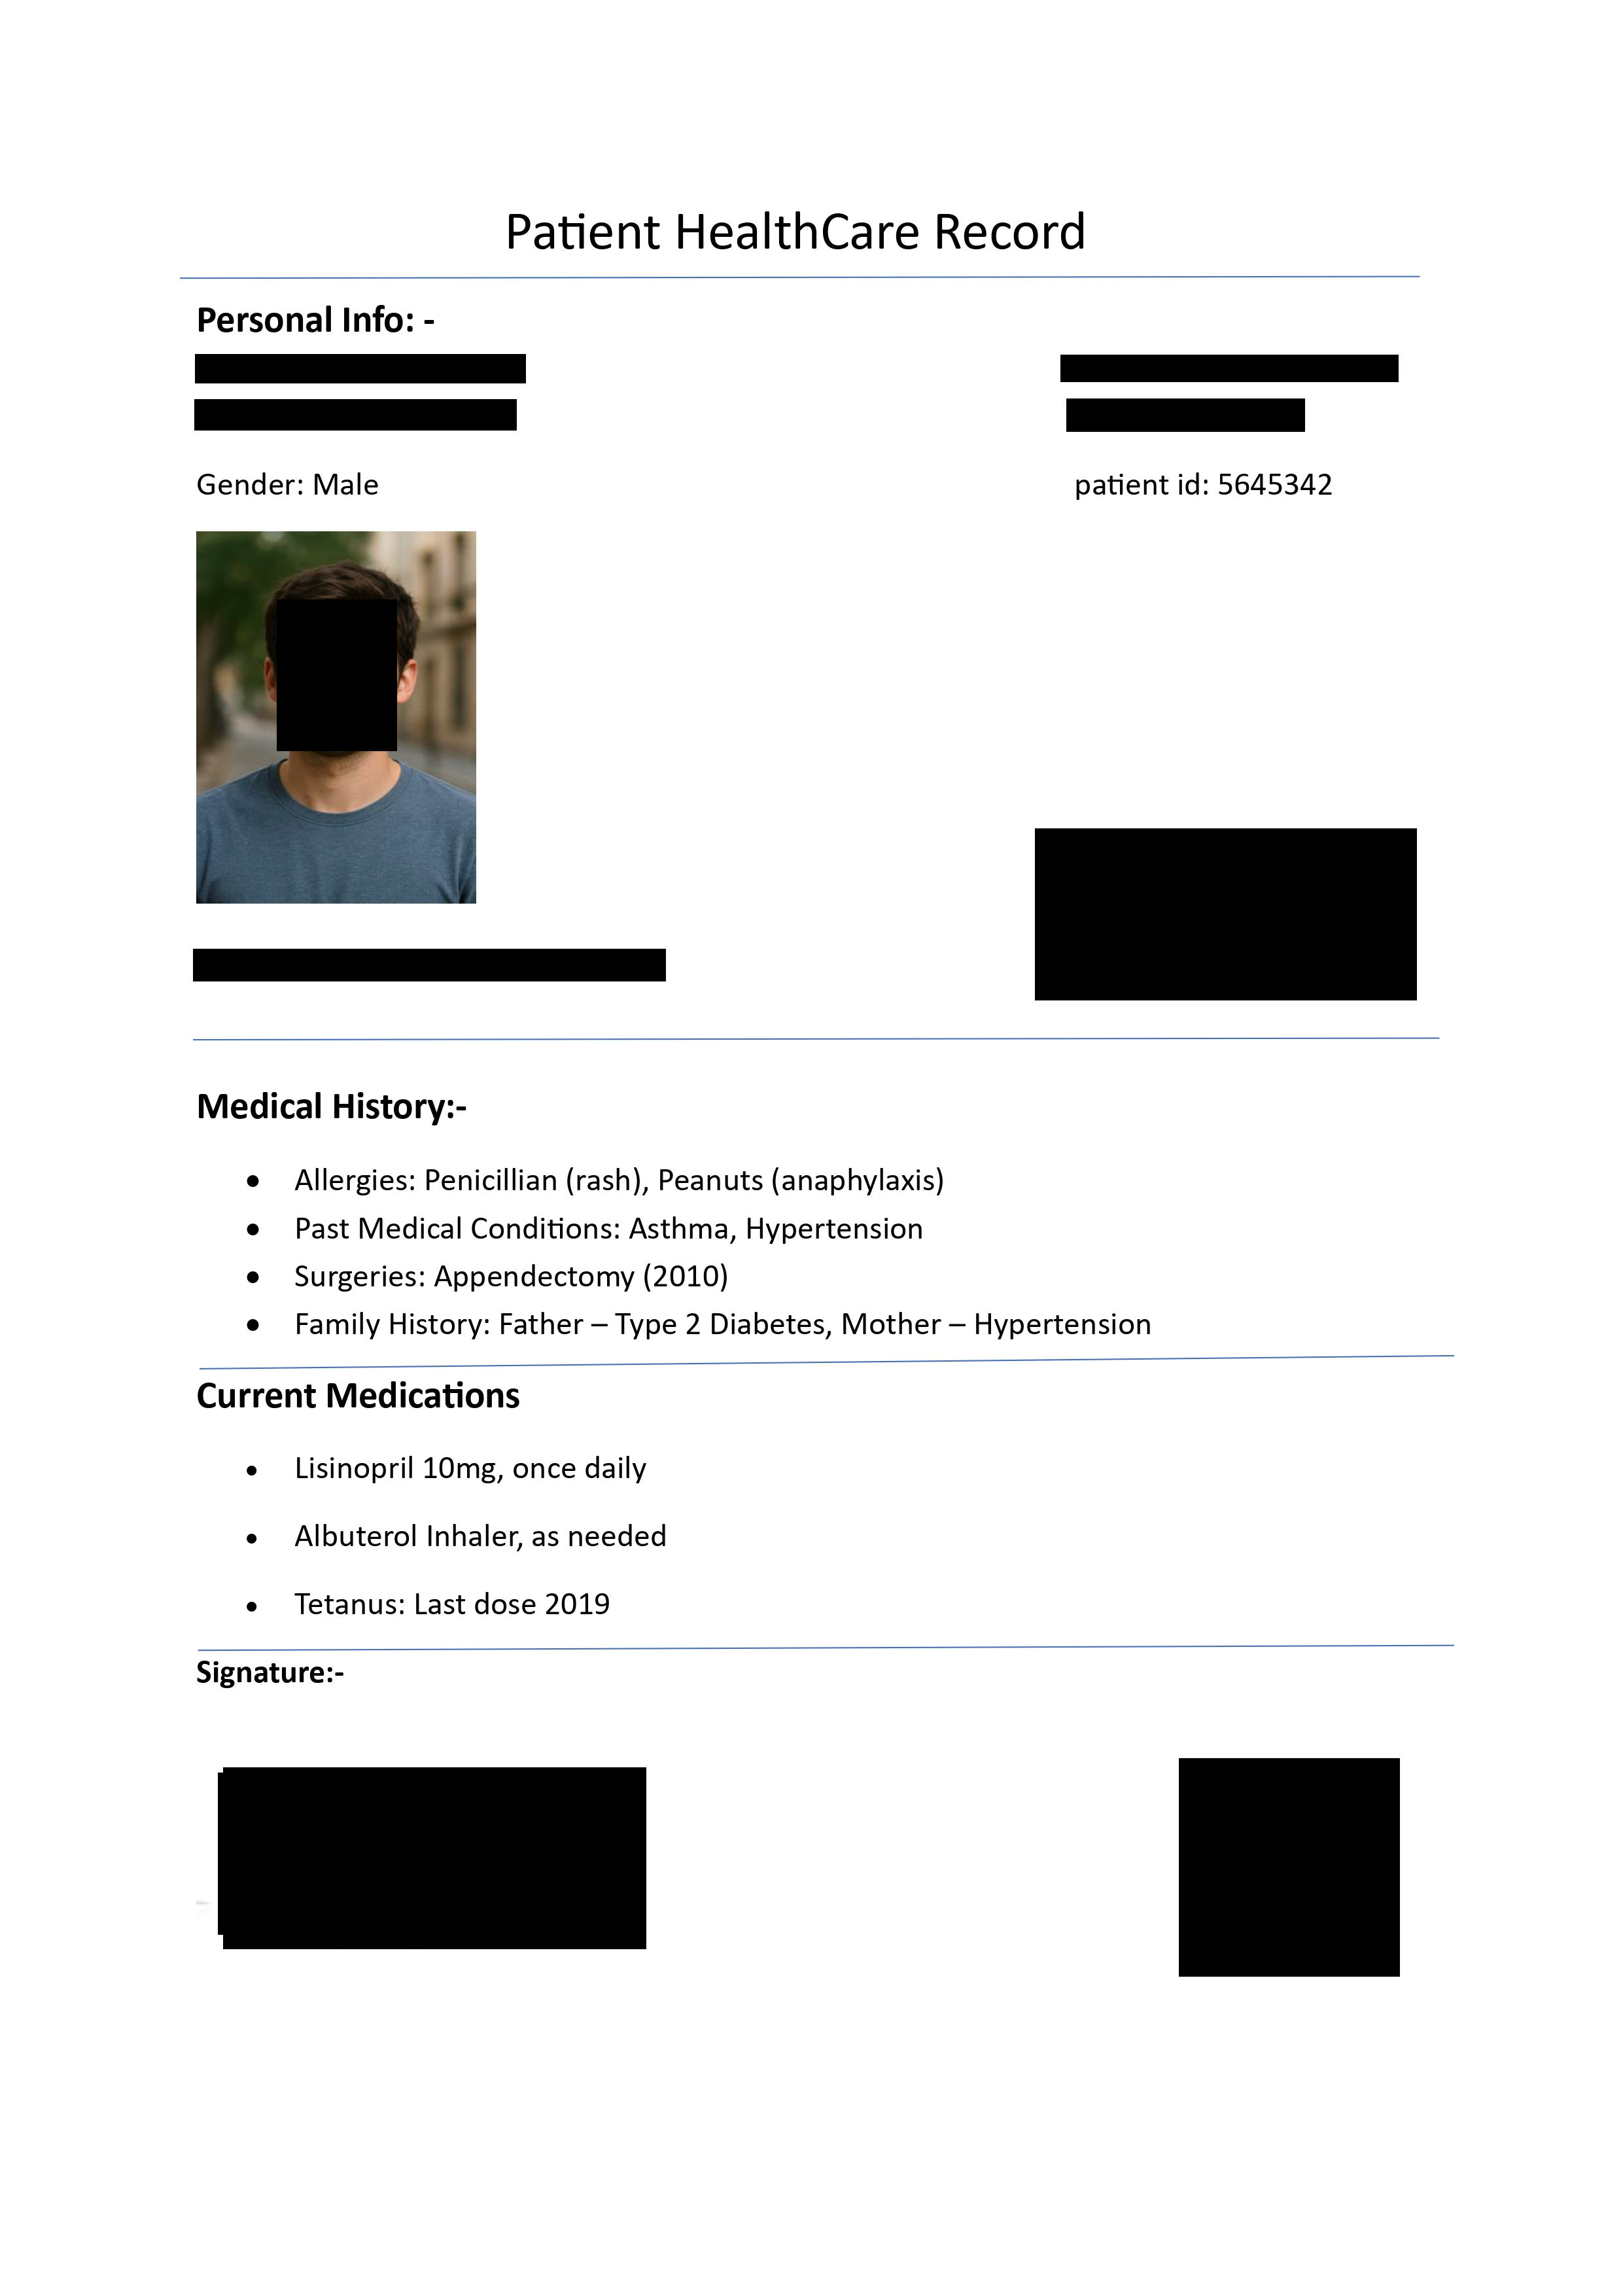

In [178]:
def blur_entities(images, entities, return_pdf=False):
    """
    Blackout bounding boxes in given images and return either PIL images or PDF.

    Args:
        images (list): List of PIL.Image objects.
        entities (list): List of dicts containing 'page' and 'bbox' or 'box'.
        return_pdf (bool): If True, return PDF bytes, else list of PIL images.

    Returns:
        list of PIL.Image OR PDF bytes
    """
    blurred_images = []

    for page_num, img in enumerate(images, start=1):
        img_copy = img.copy()
        draw = ImageDraw.Draw(img_copy)
        for ent in entities:
            if ent["page"] == page_num:  # match entity to page
                # Use 'bbox' if available, otherwise use 'box'
                if "bbox" in ent and ent["bbox"] is not None:
                    x1, y1, x2, y2 = ent["bbox"]
                else:
                    print(f"Warning: Entity on page {ent['page']} has no valid 'bbox' or 'box': {ent}")
                    continue # Skip if neither 'bbox' nor 'box' is present or is None

                # Draw black rectangle over the detected area
                draw.rectangle([x1, y1, x2, y2], fill="black")
        blurred_images.append(img_copy)

    if return_pdf:
        pdf_bytes = BytesIO()
        blurred_images[0].save(
            pdf_bytes, format="PDF", save_all=True, append_images=blurred_images[1:]
        )
        pdf_bytes.seek(0)
        return pdf_bytes.getvalue()
    else:
        return blurred_images

blurred_images = blur_entities(images, pii_detections)

# Save the first blurred image to a file
if blurred_images:
    blurred_images[0].save("blurred_image.png", format="PNG")
    print("Blurred image saved as blurred_image.png")

# Display the blurred image
from IPython.display import display
display(Image.open("blurred_image.png"))